<a href="https://colab.research.google.com/github/Sapienza-AI-Lab/esercitazione6-22-23/blob/main/Exercise2.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

# Esercizio 2
In questo esercizio utilizzerete il dataset Heart Disease per costruire un modello in grado di predire se un paziente ha o meno una malattia cardiaca. Il dataset è composto da 303 pazienti, ognuno dei quali è descritto da 13 attributi. L'attributo target è un valore intero che va da 0 (assenza) a 4.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve, train_test_split
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

### Caricamento del dataset

Attributes:
* Age
* Sex:
    * Male -> 1
    * Female -> 0
* Chest Pain Type:
    * angina -> 1
    * abnang -> 2
    * notang -> 3
    * asympt -> 4
* Resting Blood Pressure
* Cholesterol
* Fasting Blood Sugar:
    * < 120 -> 1
    * \>= 120 -> 0
* Resting ECG:
    * norm -> 0
    * abn -> 1
    * hyper -> 2
* Max Heart Rate
* Exercise Induced Angina:
    * yes -> 1
    * no -> 0
* Oldpeak
* Slope:
    * up -> 1
    * flat -> 2
    * down -> 3
* Number of vessels colored
* Thal:
    * norm -> 3
    * fixed -> 6
    * rever -> 7
* Target:
    * 0 -> no disease
    * 1,2,3,4 -> disease



In [233]:
cols = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','target']
xcols = cols[0:-1]
ycol = cols[-1]

!wget -O processed.cleveland.data https://raw.githubusercontent.com/Sapienza-AI-Lab/esercitazione6-22-23/main/data/processed.cleveland.data

df = pd.read_csv('processed.cleveland.data', header=None, index_col=None, names=cols, na_values=['?'])
df.head()

--2023-07-16 22:52:47--  https://raw.githubusercontent.com/Sapienza-AI-Lab/esercitazione6-22-23/main/data/processed.cleveland.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18461 (18K) [text/plain]
Saving to: ‘processed.cleveland.data’

processed.cleveland 100%[===================>]  18.03K  --.-KB/s    in 0s      

2023-07-16 22:52:47 (40.8 MB/s) - ‘processed.cleveland.data’ saved [18461/18461]



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [234]:
df = df.dropna()

In [235]:
X = df[xcols]
m, n = X.shape

# Binarize the target
y = (df[ycol] > 0).astype(int)

In [236]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [237]:
# Normalize the data
normalize = True

if normalize:
    xmean = X_train.mean()
    xstd = X_train.std()
    # Note that we use the mean and std of the training set to normalize both the training and test sets
    X_train = (X_train - xmean)/xstd
    X_test = (X_test - xmean)/xstd

In [240]:
print(y)

0      0
1      1
2      1
3      0
4      0
      ..
297    1
298    1
299    1
300    1
301    1
Name: target, Length: 297, dtype: int64


### Define the model

In [10]:
# Define logistic regression model
model = LogisticRegression(solver='lbfgs', n_jobs=-1)

### Grid Search

 il codice esegue una grid search per trovare i migliori parametri del modello utilizzando la metrica di accuratezza come metrica di valutazione e la strategia di cross-validation specificata. Il processo di grid search viene eseguito su più parametri di regolarizzazione ('C') generati in modo logaritmico.

In [11]:
# Define scorer
scorer = make_scorer(accuracy_score)

# Define grid search parameters
grid = dict()
grid['C'] = np.logspace(-6, 3, 10)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=scorer, error_score=0)

In [12]:
# Perform grid search
start = time.time()
grid_result = grid_search.fit(X_train, y_train)
end = time.time()
print('Grid search time =', end - start)

Grid search time = 2.6431915760040283


In [13]:
# Summarize results
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best: 0.822961 using {'C': 0.1}
0.523227 (0.008011) with: {'C': 1e-06}
0.523227 (0.008011) with: {'C': 1e-05}
0.523227 (0.008011) with: {'C': 0.0001}
0.801773 (0.015547) with: {'C': 0.001}
0.818617 (0.041322) with: {'C': 0.01}
0.822961 (0.057372) with: {'C': 0.1}
0.822961 (0.057372) with: {'C': 1.0}
0.818794 (0.060182) with: {'C': 10.0}
0.818794 (0.060182) with: {'C': 100.0}
0.818794 (0.060182) with: {'C': 1000.0}


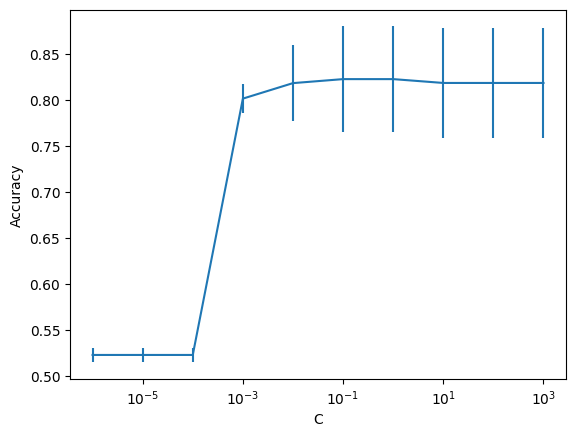

In [14]:
# Plot grid search results
plt.errorbar(grid['C'], means, yerr=stds)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

In [15]:
# Define logistic regression model with best parameters
model = LogisticRegression(solver='lbfgs', n_jobs=-1, C=grid_result.best_params_['C'])

### Learning Curves

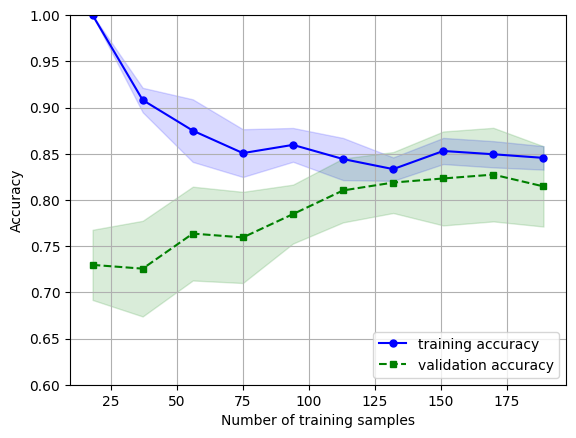

In [16]:
# Plot learning curve
scorer = make_scorer(accuracy_score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.show()

### Train

In [17]:
# Fit model on all training data
model.fit(X_train, y_train)

LogisticRegression(C=0.1, n_jobs=-1)

### Test

In [18]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy =', accuracy)

Test accuracy = 0.9


### Plot model coefficients

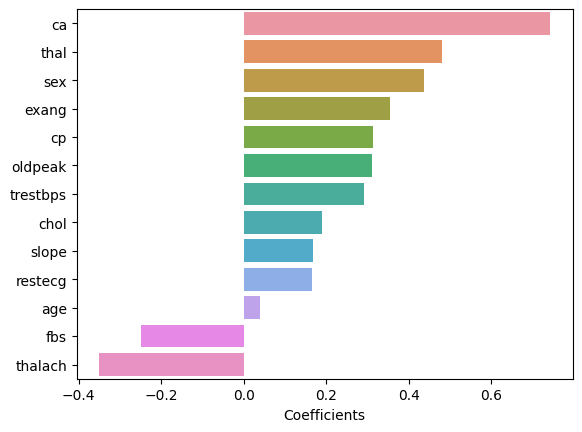

In [19]:
# Plot model coefficients
coeffs = pd.DataFrame(model.coef_, columns=xcols)
coeffs = coeffs.transpose()
coeffs.columns = ['Coefficients']
coeffs = coeffs.sort_values(by='Coefficients', ascending=False)
sns.barplot(x=coeffs['Coefficients'], y=coeffs.index)
plt.show()


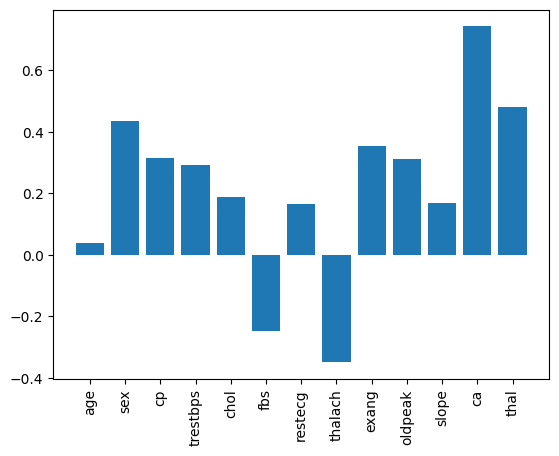

In [20]:
# Plot model coefficients without using only matplotlib
plt.bar(range(n), model.coef_[0])
plt.xticks(range(n), xcols, rotation=90)
plt.show()

# Task: Ripetete l'analisi e l'addestramento sul dataset YearPredictionMSD:

Il dataset Year Prediction MSD si puà scaricare da questo link: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD

![YPMSD](https://github.com/Sapienza-AI-Lab/esercitazione6-22-23/blob/main/data/ypmsd.jpg?raw=1)
- **Nota 1:** Il dataset è molto grande. Per testare la procedura di analisi e la correttezza del codice, prima
provate su un sottoinsieme dei dati.
- **Nota 2:** Il problema può essere trattato come un problema di classificazione o di regressione. Voi iniziate a risolverlo come classificazione, poi, se volete, potete provare a risolverlo come regressione.


In [289]:
features = ['year', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15',
            't16', 't17', 't18', 't1 9', 't20', 't21', 't22', 't23', 't24', 't25', 't26', 't27', 't28', 't29', 't30',
            't31', 't32', 't33', 't34', 't35', 't36 ', 't37', 't38', 't39', 't40', 't41', 't42', 't43', 't44', 't45',
            't46', 't47', 't48', 't49', 't50', 't51', 't52', 't53' , 't54', 't55', 't56', 't57', 't58', 't59', 't60',
            't61', 't62', 't63', 't64', 't65', 't66', 't67', 't68', 't69', 't70', 't71', 't72', 't73', 't74', 't75',
            't76', 't77', 't78', 't79', 't80', 't81', 't82', 't83', 't84', 't85', 't86', 't87', 't88', 't89', 't90']

In [290]:
dataframe2 = pd.read_csv('YearPredictionMSD.txt', names=features)

dataframe2.head()

,year,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t81,t82,t83,t84,t85,t86,t87,t88,t89,t90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [265]:
#dataframe2.shape

(515345, 91)

In [266]:
#dataframe2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515345 entries, 0 to 515344
Data columns (total 91 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   year    515345 non-null  int64  
 1   t1      515345 non-null  float64
 2   t2      515345 non-null  float64
 3   t3      515345 non-null  float64
 4   t4      515345 non-null  float64
 5   t5      515345 non-null  float64
 6   t6      515345 non-null  float64
 7   t7      515345 non-null  float64
 8   t8      515345 non-null  float64
 9   t9      515345 non-null  float64
 10  t10     515345 non-null  float64
 11  t11     515345 non-null  float64
 12  t12     515345 non-null  float64
 13  t13     515345 non-null  float64
 14  t14     515345 non-null  float64
 15  t15     515345 non-null  float64
 16  t16     515345 non-null  float64
 17  t17     515345 non-null  float64
 18  t18     515345 non-null  float64
 19  t1 9    515345 non-null  float64
 20  t20     515345 non-null  float64
 21  t21     51

In [267]:
#dataframe2.describe()

,year,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t81,t82,t83,t84,t85,t86,t87,t88,t89,t90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


In [291]:
df2 = dataframe2.dropna() #rimuove null
df2 = df2.sample(frac=0.3, random_state=42) #lascia il 30% dei campioni

print(len(df2))

154604


Text(0, 0.5, 'Number of songs')

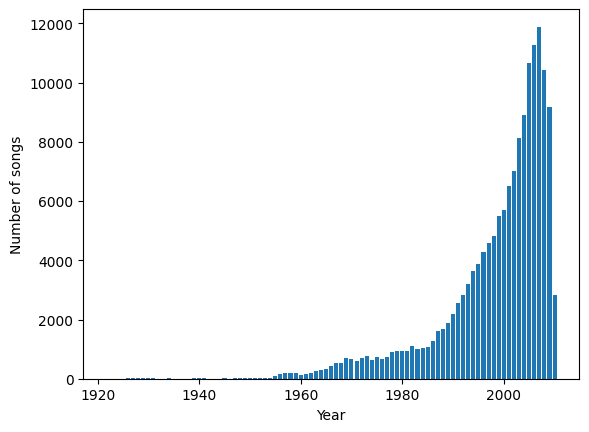

In [292]:
nsongs = {}
for y in range(1922,2012):
    nsongs[y] = len(df2[df2.year==y])
yrs = range(1922,2011)
values = [nsongs[y] for y in yrs]
plt.bar(yrs, values, align='center')
plt.xlabel("Year")
plt.ylabel("Number of songs")

In [293]:
#df2 = df2[df2.groupby(df2.columns[0])[df2.columns[0]].transform('count') > 41]
#perche non c'erano abbastanza samples per ogni classe per la crossvalidation

X = df2.iloc[:, 1:] #salta il primo e considera metà degli attr
m, n = X.shape
y = (df2['year'] > 2002).astype(int)

In [273]:
print(y)

201297    1
75576     0
46834     1
500468    1
90320     0
         ..
294251    0
227426    1
90502     0
354817    1
234860    1
Name: year, Length: 154604, dtype: int64


In [294]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [295]:
# Normalize the data
normalize = True

if normalize:
    xmean = X_train.mean()
    xstd = X_train.std()
    # Note that we use the mean and std of the training set to normalize both the training and test sets
    X_train = (X_train - xmean)/xstd
    X_test = (X_test - xmean)/xstd

In [296]:
model = LogisticRegression(solver='lbfgs', n_jobs=-1)

In [297]:
# Define scorer
scorer = make_scorer(accuracy_score)

# Define grid search parameters
grid = dict()
grid['C'] = np.logspace(-6, 3, 10)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=scorer, error_score=0)

In [298]:
# Perform grid search
start = time.time()
grid_result = grid_search.fit(X_train, y_train)
end = time.time()
print('Grid search time =', end - start)

Grid search time = 53.210564613342285


In [299]:
# Summarize results
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best: 0.711205 using {'C': 100.0}
0.536177 (0.000555) with: {'C': 1e-06}
0.643354 (0.002570) with: {'C': 1e-05}
0.695641 (0.003576) with: {'C': 0.0001}
0.710478 (0.001697) with: {'C': 0.001}
0.711205 (0.001710) with: {'C': 0.01}
0.711133 (0.001571) with: {'C': 0.1}
0.711189 (0.001590) with: {'C': 1.0}
0.711189 (0.001580) with: {'C': 10.0}
0.711205 (0.001564) with: {'C': 100.0}
0.711197 (0.001576) with: {'C': 1000.0}


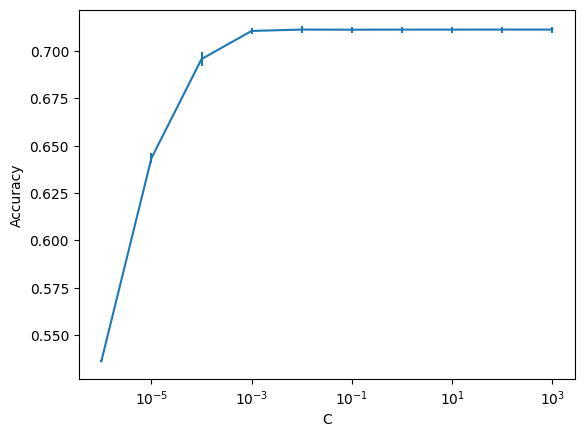

In [300]:
# Plot grid search results
plt.errorbar(grid['C'], means, yerr=stds)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

In [301]:
# Define logistic regression model with best parameters
model = LogisticRegression( n_jobs=-1, solver='lbfgs', C=grid_result.best_params_['C'])

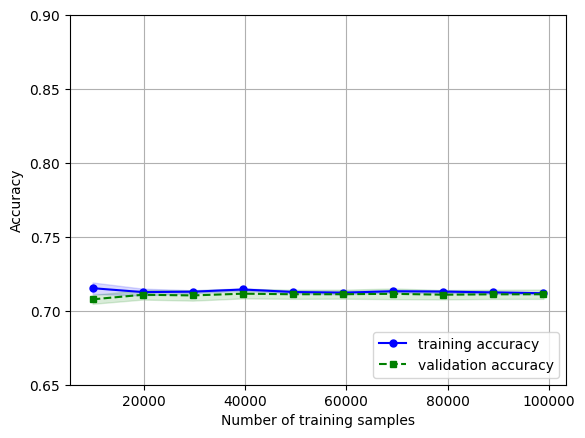

In [302]:
# Plot learning curve
scorer = make_scorer(accuracy_score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=cv, scoring=scorer, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.65, 0.9])
plt.show()

In [303]:
model.fit(X_train, y_train)

LogisticRegression(C=100.0, n_jobs=-1)

In [304]:
# Predict on test set
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy =', accuracy)

Test accuracy = 0.7101969535267294


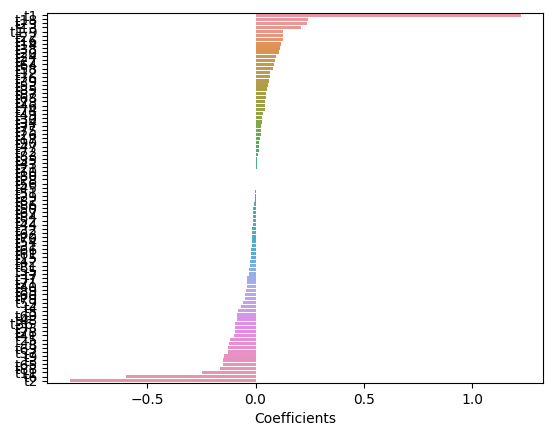

In [305]:
# Plot model coefficients
coeffs = pd.DataFrame(model.coef_, columns=features[1:])
coeffs = coeffs.transpose()
coeffs.columns = ['Coefficients']
coeffs = coeffs.sort_values(by='Coefficients', ascending=False)
sns.barplot(x=coeffs['Coefficients'], y=coeffs.index)
plt.show()

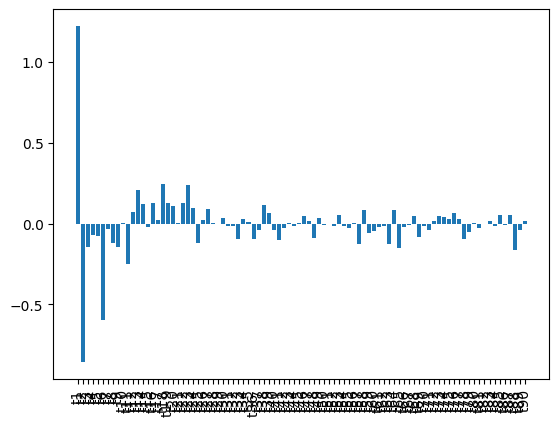

In [306]:
# Plot model coefficients without using only matplotlib
plt.bar(range(n), model.coef_[0])
plt.xticks(range(n), features[1:], rotation=90)
plt.show()